In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

from prophet import Prophet

In [12]:
# --- 1. 데이터 수집 (Gold) ---
df = yf.download("GC=F", start="2020-01-01", end="2025-04-15")[['Close']]
df = df.dropna()
df

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,GC=F
Date,
2020-01-02,1524.500000
2020-01-03,1549.199951
2020-01-06,1566.199951
2020-01-07,1571.800049
2020-01-08,1557.400024
...,...
2025-04-08,2968.399902
2025-04-09,3056.500000


In [13]:
# 멀티인덱스를 단일 컬럼으로 평탄화 (tuple to string)
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df.columns

Index(['Close_GC=F'], dtype='object')

In [16]:
## Prophet과 LSTM, GRU 용 전처리

# Prophet
df_prophet = pd.DataFrame()
df_prophet['ds'] = df.index
df['y'] = df['Close_GC=F']
df_prophet['y'] = df['y'].astype(float).values.flatten()

# LSTM & GRU
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['y']])

In [17]:
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y_seq = create_sequences(scaled_data, SEQ_LEN)

In [18]:
# 훈련/테스트 분할
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [19]:
# LSTM 모델
model_lstm = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# --- 4. GRU 모델 ---
model_gru = Sequential([
    GRU(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

In [16]:
# # --- 5. Prophet 모델 ---
# df_prophet = df.copy()
# df_prophet['ds'] = df_prophet.index
# df_prophet = df_prophet[['ds', 'y']]

# #형식 정리
# df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
# df_prophet = df_prophet.dropna()
# df_prophet.isna().sum()


,,0
Price,Ticker,
ds,,0
y,GC=F,0


In [21]:
# Prophet 실행
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkxkyqqpo/zmp0j8nm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkxkyqqpo/27dib5i_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8405', 'data', 'file=/tmp/tmpkxkyqqpo/zmp0j8nm.json', 'init=/tmp/tmpkxkyqqpo/27dib5i_.json', 'output', 'file=/tmp/tmpkxkyqqpo/prophet_modeldax82f88/prophet_model-20250415065238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:52:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


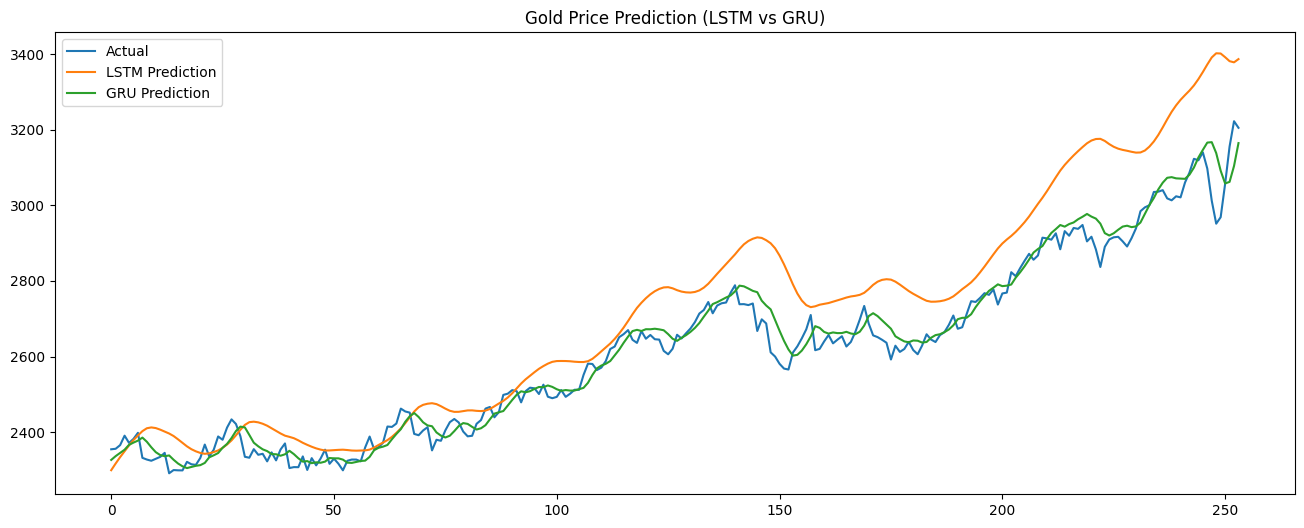

In [22]:
# --- 6. 예측 결과 시각화 ---
pred_lstm = scaler.inverse_transform(model_lstm.predict(X_test))
pred_gru = scaler.inverse_transform(model_gru.predict(X_test))
actual = scaler.inverse_transform(y_test)

plt.figure(figsize=(16, 6))
plt.plot(actual, label='Actual')
plt.plot(pred_lstm, label='LSTM Prediction')
plt.plot(pred_gru, label='GRU Prediction')
plt.title("Gold Price Prediction (LSTM vs GRU)")
plt.legend()
plt.show()

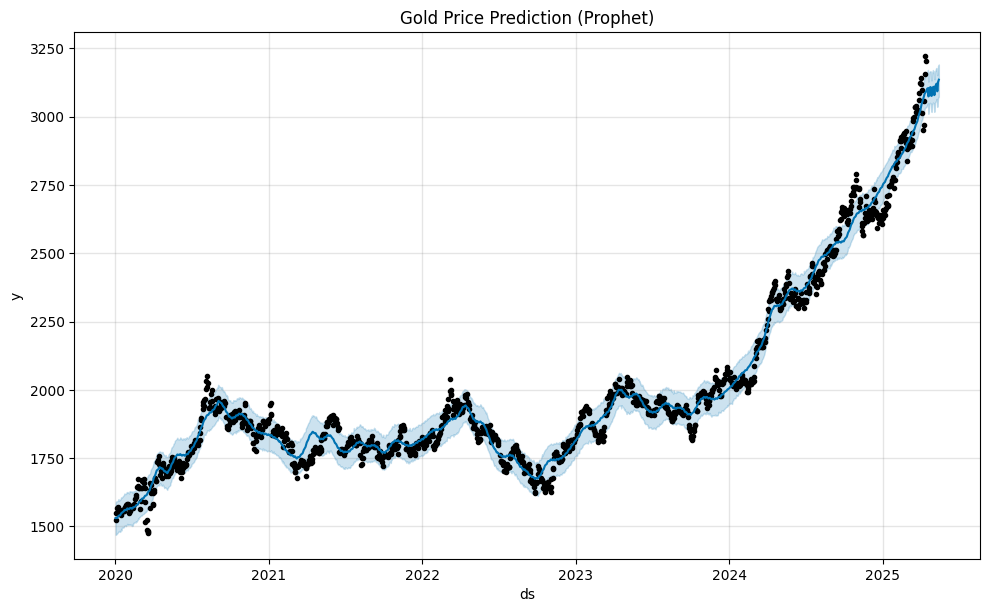

In [23]:
# Prophet 시각화
model_prophet.plot(forecast)
plt.title("Gold Price Prediction (Prophet)")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


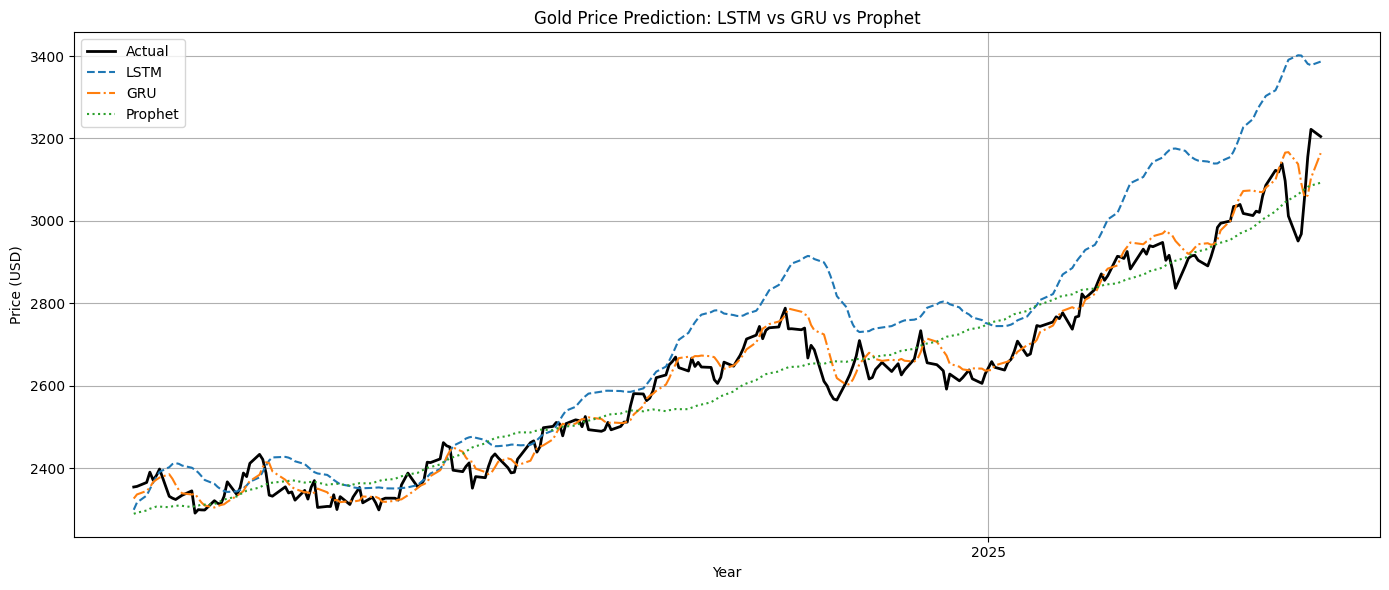

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# 실제값 (역정규화)
actual = scaler.inverse_transform(y_test)

# LSTM & GRU 예측 (역정규화)
pred_lstm = scaler.inverse_transform(model_lstm.predict(X_test))
pred_gru = scaler.inverse_transform(model_gru.predict(X_test))

# x축용 날짜 생성 (테스트 구간 날짜)
test_dates = df_prophet['ds'][-len(actual):].reset_index(drop=True)

# Prophet 예측 데이터 추출 (최근 기간만)
forecast_plot = forecast.set_index('ds')
prophet_pred = forecast_plot.loc[test_dates]['yhat'].values  # Prophet 예측을 테스트 구간과 맞춤

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label='Actual', color='black', linewidth=2)
plt.plot(test_dates, pred_lstm, label='LSTM', linestyle='--')
plt.plot(test_dates, pred_gru, label='GRU', linestyle='-.')
plt.plot(test_dates, prophet_pred, label='Prophet', linestyle=':')

# 연도 단위로 x축 설정
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title("Gold Price Prediction: LSTM vs GRU vs Prophet")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [26]:
# 1. LSTM
mae_lstm = mean_absolute_error(actual, pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(actual, pred_lstm))

# 2. GRU
mae_gru = mean_absolute_error(actual, pred_gru)
rmse_gru = np.sqrt(mean_squared_error(actual, pred_gru))

# 3. Prophet
mae_prophet = mean_absolute_error(actual, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(actual, prophet_pred))


In [27]:
print("📊 Prediction Error Metrics:")
print(f"LSTM    - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"GRU     - MAE: {mae_gru:.4f}, RMSE: {rmse_gru:.4f}")
print(f"Prophet - MAE: {mae_prophet:.4f}, RMSE: {rmse_prophet:.4f}")


📊 Prediction Error Metrics:
LSTM    - MAE: 105.2437, RMSE: 133.7690
GRU     - MAE: 28.4800, RMSE: 38.7015
Prophet - MAE: 52.4388, RMSE: 62.6959
